<a href="https://colab.research.google.com/github/karthikstar/stock-screener/blob/main/Stock_Screener.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By Elangovan Karthikeyan

## Stock Screener
We create a stock screener in python that leverages mean reversion and momentum to generate buy and sell signals on all stocks in the S&P 500. We will also use analyst ratings to filter out stocks to buy only if sentiment is bullish.

This trading algorithm will use mean reversion + momentum + analyst ratings to decide whether to buy, sell or hold the stock. We will backtest the algorithm using mean reversion + momenmtum to capitalise on the law of averages and trends. The algo will do a final filter to return stocks with bullish coverage to buy, and bearish ones to sell.

Key Steps include:
- Data collection using yahoo finance in python
- Derive technical analysis through custom python functions
- Create logic for buy and sell conditions
- Create a back testing function to compare the performance of our algorithm to the buy and hold strategy.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import yfinance as yf
from datetime import date
from dateutil.relativedelta import relativedelta

### Get All Stocks in the S&P 500

In [ ]:
import requests
from bs4 import BeautifulSoup

url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Add headers to mimic a browser request
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

try:
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)

    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the table containing the S&P 500 list using the provided classes
    table = soup.find('table', {'class': 'wikitable'})

    if table:
        # Extract tickers from the table (assuming the ticker is in the first column of the table body rows)
        sp500_tickers = []
        rows = table.find_all('tr')[1:] # Skip the header row
        for row in rows:
            cols = row.find_all('td')
            if cols:
                # Extract the text from the first column, which is the Symbol
                ticker = cols[0].text.strip()
                # Some tickers on Wikipedia have a '.' which needs to be replaced with '-' for yfinance
                ticker = ticker.replace('.', '-')
                sp500_tickers.append(ticker)

        print(sp500_tickers)
    else:
        print("Could not find the table with S&P 500 tickers on the page using the provided classes.")

except requests.exceptions.RequestException as e:
    print(f"Error fetching the page: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'AON', 'APA', 'APO', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK-B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'XYZ', 'BK', 'BA', 'BKNG', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF-B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CAT', 'CBOE', 'CBRE', 'CDW', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'COIN', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DDOG', '

## Create Algorithm Logic

- **Mean Reversion + Momentum:**
  - WHEN `Low < Bollinger Band Lower` AND `(RSI < 30 OR MFI < 20)` THEN **"BUY"**
  - WHEN `High > Bollinger Band Upper` AND `(RSI > 70 OR MFI > 80)` THEN **"SELL"**

---

### How to Calculate Bollinger Bands?

- **Definition:** "to provide a relative definition of high and low prices of a market.  By definition, prices are high at the upper band and low at the lower band."  
  [Wikipedia: Bollinger Bands](https://en.wikipedia.org/wiki/Bollinger_Bands)

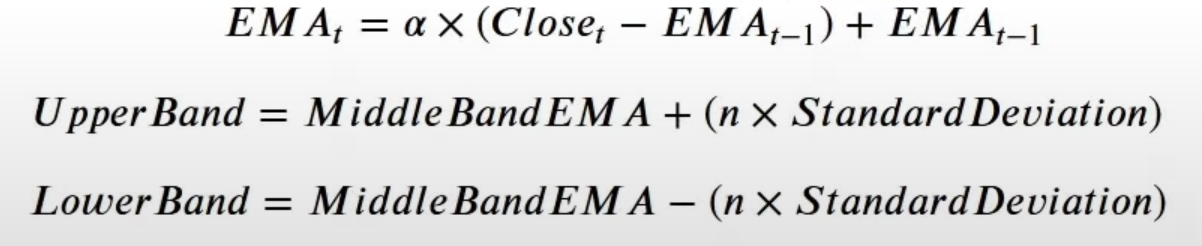

### How to Calculate RSI?

- **Definition:** "to chart the current and historical strength or weakness of a stock or market  
  based on the closing prices of a recent trading period."  
  [Wikipedia: RSI](https://en.wikipedia.org/wiki/Relative_strength_index)

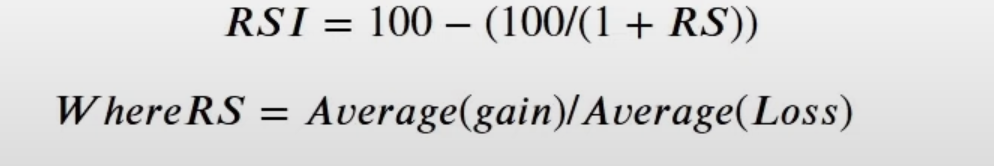

### How to Calculate Money Flow Index?

- **Definition:** "The money flow index (MFI) is an oscillator that ranges from 0 to 100.  It is used to show the money flow (an approximation of the dollar value of a day's trading) over several days."  
  [Wikipedia: Money Flow Index](https://en.wikipedia.org/wiki/Money_flow_index)
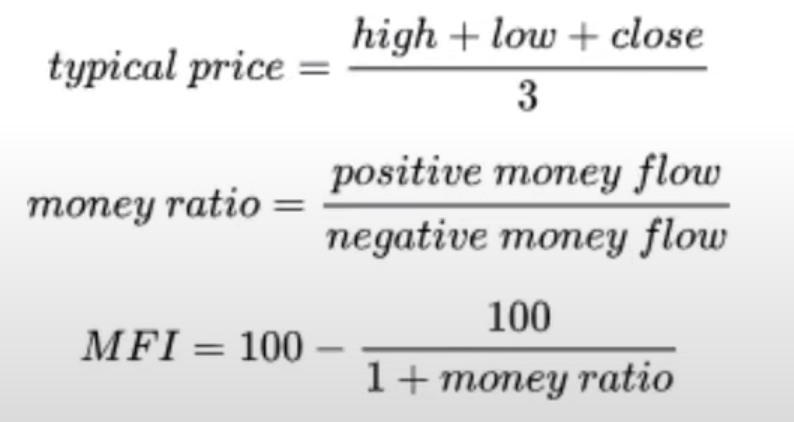

In [ ]:
# Get today's date
end = date.today()

#Subtract 5 years. Back test will be 5 years worth of data.

start = end - relativedelta(years=5)

def bollinger_bands(df,window=20):
    df[f'SMA{window}']=df['Close'].rolling(window=window).mean()

    df[f'STD{window}']=df['Close'].rolling(window=window).std()

    df[f'Upper Band {window}'] = df[f'SMA{window}'] + (df[f'STD{window}']*2)
    df[f'Lower Band {window}'] = df[f'SMA{window}'] - (df[f'STD{window}']*2)

    return df

def create_rsi(df,window=14):
    delta=df['Close'].diff()

    gain=(delta.where(delta>0,0)) #Separate gains from losses
    loss=(-delta.where(delta<0,0))

    #Calc avg gain and loss
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    #Calc Relative Strength (RS)
    rs = avg_gain/avg_loss

    rsi_value = 100-(100/(1+rs))

    df['rsi'] = rsi_value

    return df

def money_flow_index(df,window=14):
    typical_price=(df['High']+df['Low']+df['Close'])/3

    #calc Raw Money Flow
    raw_money_flow = typical_price*df['Volume']

    #calc pos and neg money flow
    positive_flow = raw_money_flow.where(typical_price > typical_price.shift(1),0)
    negative_flow = raw_money_flow.where(typical_price < typical_price.shift(1),0)

    #calc money flow ratio
    window=14
    positive_mf_sum = positive_flow.rolling(window=window).sum()
    negative_mf_sum = negative_flow.rolling(window=window).sum()
    money_flow_ratio = positive_mf_sum / negative_mf_sum

    #calc money flow index (mfi)
    mfi = 100-(100/(1+money_flow_ratio))

    #add mfi to dataframe
    df['mfi'] = mfi

    return df

# custom function with trading algorithm logic
def algorithm(ticker,start=start,end=end,interval='1d'):
    df = yf.download(ticker,start=start,end=end,interval=interval)
    df.columns=[col[0] for col in df.columns]

    #calc EMA and BB
    df = bollinger_bands(df=df,window=12)
    df = bollinger_bands(df=df,window=20)
    df = bollinger_bands(df=df,window=50)

        #Calc RSI for momentum
    df = create_rsi(df=df,window=14)

    #Calc MFI for momentum
    df = money_flow_index(df=df,window=14)

    #Create Logic for buy and sell signals
    #Initialize values
    low = df['Low']
    high = df['High']
    sma12 = df['SMA12']
    sma20 = df['SMA20']
    sma50 = df['SMA50']
    bollingerupper20 = df['Upper Band 20']
    bollingerlower20 = df['Lower Band 20']
    bollingerupper50 = df['Upper Band 50']
    bollingerlower50 = df['Lower Band 50']
    rsi = df['rsi']
    mfi = df['mfi']


    #initialize buy_signal, sell_signal, action list
    buy_signal = []
    sell_signal = []
    action = []

    for i in range(len(df)):
        low_val = low[i]
        high_val = high[i]
        sma12_val = sma12[i]
        sma20_val = sma20[i]
        sma50_val = sma50[i]
        bollingerlower_val20 = bollingerlower20[i]
        bollingerupper_val20 = bollingerupper20[i]
        bollingerlower_val50 = bollingerlower50[i]
        bollingerupper_val50 = bollingerupper50[i]
        rsi_val = rsi[i]
        mfi_val = mfi[i]

        #buy Logic
        buy_condition = (low_val < bollingerlower_val20) and (rsi_val < 30 and mfi_val < 25)

        #sell logic
        sell_condition = (high_val > bollingerlower_val20) and (rsi_val > 70 and mfi_val > 75)

        #scatter plot values for buy and sell signals
        if buy_condition: #if buy_condition is true
            buy_signal.append(low_val*0.95)
            sell_signal.append(np.nan)
            action.append("Buy")

        elif sell_condition:
            sell_signal.append(high_val*1.05)
            buy_signal.append(np.nan)
            action.append("Sell")
        else:
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)
            action.append("Hold")

    #add new columns to dataframe
    df['buy_signal'] = buy_signal
    df['sell_signal'] = sell_signal
    df['action'] = action

    #Back testing Logic - compare algorithm to buy and hold method.
    initial_cash = 10000
    cash = initial_cash
    position = 0 #initially holding no stock
    portfolio_value = [] #track portfolio value over time

    #Buy and Hold Value
    share_cost = df['Open'].iloc[0]
    num_shares = initial_cash/share_cost
    df['Buy_Hold_Value'] = df['Close']*num_shares

    #Iterate over each row in dataframe to simulate portfolio updates
    for i in range(0,len(df)):
        action = df['action'].iloc[i]
        price = df['Close'].iloc[i]

        #If action is 'Buy'
        if action =='Buy' and cash > 0: #Check if there's cash available
            position = cash/price #Buy as much as we can with available cash
            cash = 0 #ALL cash is used up in this position

        elif action == 'Sell' and position > 0: #Check if there's stock to sell
            cash = position * price #our new cash position after selling all stock
            position = 0 #all stock has been sold

        elif action == 'Hold':
            pass

        portfolio_value.append(cash+position*price) #calc portfolio value at end of the day

    #add new column to dataframe
    df['Portfolio Value'] = portfolio_value

    return df


In [ ]:
df = algorithm(ticker='MMM', start=start, end=end, interval='1d')
df

/tmp/ipython-input-481807205.py:63: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker,start=start,end=end,interval=interval)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  low_val = low[i]
/tmp/ipython-input-481807205.py:99: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  high_val = high[i]
/tmp/ipython-input-481807205.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as lab

,Close,High,Low,Open,Volume,SMA12,STD12,Upper Band 12,Lower Band 12,SMA20,...,STD50,Upper Band 50,Lower Band 50,rsi,mfi,buy_signal,sell_signal,action,Buy_Hold_Value,Portfolio Value
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-21,111.729111,115.405872,110.538147,114.928104,4678393,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hold,9721.652620,10000.000000
2020-09-22,112.407692,113.328617,111.078246,111.521403,2516145,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hold,9780.696597,10000.000000
2020-09-23,110.448112,113.723265,110.178061,112.532301,2688847,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hold,9610.191786,10000.000000
2020-09-24,111.078239,112.144571,109.451056,110.371968,1877361,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hold,9665.019712,10000.000000
2020-09-25,110.974380,111.465998,109.998058,110.309658,2330884,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hold,9655.982849,10000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-15,156.660004,158.380005,155.250000,158.000000,3219500,155.402501,2.184415,159.771332,151.033671,155.263268,...,3.480224,160.538504,146.617607,51.799194,48.701130,NaN,NaN,Hold,13631.130913,13664.827404
2025-09-16,156.500000,157.479996,153.630005,156.899994,2208600,155.314168,2.109383,159.532934,151.095403,155.480421,...,3.486163,160.657549,146.712896,49.840530,49.642964,NaN,NaN,Hold,13617.208848,13650.870922
2025-09-17,155.160004,158.539993,153.539993,156.500000,2757300,155.283335,2.108645,159.500625,151.066045,155.556914,...,3.491016,160.709796,146.745732,47.053774,43.431625,NaN,NaN,Hold,13500.614535,13533.988385


In [ ]:
#Count frequency of buy, sell, and holds in action column
action_count = df['action'].value_counts()
print(action_count)

action
Hold    1173
Sell      59
Buy       24
Name: count, dtype: int64


In [ ]:
# Combine all subplots into one figure
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    row_heights=[0.6, 0.2, 0.2],
    vertical_spacing=0.02,
    subplot_titles=("Candlestick with Buy and Sell Signals", "RSI (14)", "MFI (14)")
)

# Candlestick
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    name='Candlestick'
))

# SMA 20
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['SMA20'],
    mode='lines',
    name='SMA 20',
    line=dict(color='blue', width=1, dash='solid')
))

# SMA 50
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['SMA50'],
    mode='lines',
    name='SMA 50',
    line=dict(color='red', width=1, dash='solid')
))

# Upper Bollinger Band
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Upper Band 20'],
    mode='lines',
    name='Upper Band 20',
    line=dict(color='blue', width=1, dash='dash')
))

# Lower Bollinger Band
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Lower Band 20'],
    mode='lines',
    name='Lower Band 20',
    line=dict(color='blue', width=1, dash='dash')
))

# Upper Bollinger Band
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Upper Band 50'],
    mode='lines',
    name='Upper Band 50',
    line=dict(color='red', width=1, dash='dash')
))

# Lower Bollinger Band
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Lower Band 50'],
    mode='lines',
    name='Lower Band 50',
    line=dict(color='red', width=1, dash='dash')
))

# Buy Signals
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['buy_signal'],
    mode='markers',
    name='Buy Signal',
    marker=dict(color='green', symbol='triangle-up', size=10)
))

# Sell Signals
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['sell_signal'],
    mode='markers',
    name='Sell Signal',
    marker=dict(color='red', symbol='triangle-down', size=10)
))

# Add RSI to the second row
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['rsi'],
    mode='lines',
    name='RSI',
    line=dict(color='purple', width=2)
), row=2, col=1)

#Add MFI to the third row

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['mfi'],
    mode='lines',
    name='MFI',
    line=dict(color='brown', width=2)
), row=3, col=1)

fig.add_hline(y=80, line=dict(color='red', dash='dash'), row=3, col=1)
fig.add_hline(y=20, line=dict(color='green', dash='dash'), row=3, col=1)

# Update Layout
fig.update_layout(
    xaxis_rangeslider_visible=False,
    template="plotly"
)

fig.show()


### Stock Screener
- Filter on Stocks where the algorithm outperformed and analysts positively rate the stock

In [ ]:
result_dict = {}
for ticker in sp500_tickers:
    try: #if we run into an error for one stock, the entire script will not halt
        #Replace '.' with '-'
        ticker = ticker.replace('.','-')
        print(f'>> Now Running: {ticker}')
        df = algorithm(ticker=ticker,start=start,end=end,interval='1d')

        #Get Wall Street analyst recommendations
        #Fetch stock data
        stock = yf.Ticker(ticker)

                #Get analyst recs
        analyst_ratings = stock.recommendations
        analyst_ratings = analyst_ratings[(analyst_ratings['period'] == '0m')]

        count_buy = analyst_ratings['strongBuy'] + analyst_ratings['buy']
        count_buy = count_buy[0]
        count_sell = analyst_ratings['strongSell'] + analyst_ratings['sell']
        count_sell = count_sell[0]

        is_more_buys = count_buy > count_sell

        analyst_ratings['IsMoreBuys'] = ['Y' if a > b else 'N' for a,b in zip(analyst_ratings['strongBuy'] + analyst_ratings['buy'], analyst_ratings['strongSell'] + analyst_ratings['sell'])]

        result_dict[f'{ticker}'] = (df['Buy_Hold_Value'].iloc[-1], df['Portfolio Value'].iloc[-1], count_buy, count_sell, analyst_ratings['IsMoreBuys'].iloc[-1])

    except Exception as e:
        print(f'>> ERROR: {e}') #print the error

result_dict

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

>> Now Running: MMM



/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

>> Now Running: AOS


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ABT


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: ABBV


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ACN


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ADBE


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: AMD


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To

>> Now Running: AES


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: AFL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: A


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: APD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ABNB


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To

>> Now Running: AKAM


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: ALB


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ARE


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ALGN


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


>> Now Running: ALLE


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: LNT


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ALL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: GOOGL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: GOOG


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: MO


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: AMZN


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: AMCR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: AEE


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: AEP


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: AXP


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: AIG


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: AMT


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: AWK


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: AMP


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: AME


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: AMGN


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: APH


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: ADI


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: AON


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: APA


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: APO


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: AAPL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: AMAT


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: APTV


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ACGL


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To

>> Now Running: ADM


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To

>> Now Running: ANET


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: AJG


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: AIZ


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: T


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ATO


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ADSK


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ADP


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: AZO


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: AVB


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: AVY


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: AXON


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: BKR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: BALL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: BAC



/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

>> Now Running: BAX


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: BDX


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: BRK-B


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


>> Now Running: BBY


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: TECH


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: BIIB


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: BLK


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: BX


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: XYZ


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: BK


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: BA


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: BKNG


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: BSX


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: BMY


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: AVGO


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: BR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: BRO


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: BF-B


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: BLDR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: BG


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: BXP


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CHRW


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CDNS


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CZR


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To

>> Now Running: CPT


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

>> Now Running: CPB



/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

>> Now Running: COF


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: CAH


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: KMX


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: CCL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CARR


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: CAT


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CBOE


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To

>> Now Running: CBRE


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: CDW


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: COR


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To

>> Now Running: CNC


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: CNP


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CF


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: CRL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: SCHW



/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

>> Now Running: CHTR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CVX


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CMG


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: CB


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CHD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CI


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CINF


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CTAS


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CSCO


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: C


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CFG


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: CLX


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CME


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CMS


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: KO


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CTSH


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: COIN


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CMCSA


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CAG


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: COP


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ED


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: STZ


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CEG


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: COO


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CPRT


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


>> Now Running: GLW


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: CPAY


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: CTVA


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CSGP


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: COST


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CTRA


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: CRWD


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: CCI


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CSX


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CMI


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CVS


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: DHR


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: DRI


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: DDOG


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To

>> Now Running: DVA


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


>> Now Running: DAY


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: DECK


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: DE


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: DELL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: DAL


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


>> Now Running: DVN


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: DXCM


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: FANG


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: DLR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: DG


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: DLTR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: D


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: DPZ


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To

>> Now Running: DASH


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


>> Now Running: DOV


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: DOW


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


>> Now Running: DHI


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: DTE


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: DUK


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: DD


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: EMN


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ETN


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: EBAY


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: ECL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: EIX


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: EW


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: EA


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: ELV


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: EMR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ENPH



/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

>> Now Running: ETR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: EOG


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: EPAM


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: EQT


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: EFX


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: EQIX


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: EQR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ERIE


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ESS


/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp

>> Now Running: EL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: EG


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: EVRG


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ES


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: EXC


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: EXE


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: EXPE


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: EXPD


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: EXR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: XOM


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: FFIV


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: FDS


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: FICO


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


>> Now Running: FAST


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: FRT


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: FDX


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: FIS


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: FITB


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: FSLR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: FE


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To

>> Now Running: FI


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: F


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: FTNT


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: FTV


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: FOXA


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


>> Now Running: FOX


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> ERROR: 'period'
>> Now Running: BEN


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: FCX


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: GRMN


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: IT


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: GE


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: GEHC


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To

>> Now Running: GEV


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: GEN


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: GNRC


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: GD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: GIS


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GIS']: ConnectionError('Failed to perform, curl: (56) Recv failure: Connection reset by peer. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> ERROR: single positional indexer is out-of-bounds
>> Now Running: GM


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: GPC


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: GILD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: GPN


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: GL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: GDDY


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: GS


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: HAL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: HIG


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: HAS


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: HCA


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: DOC


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: HSIC


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: HSY


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: HPE


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: HLT


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: HOLX


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: HD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: HON


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: HRL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: HST


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: HWM


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: HPQ


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: HUBB


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: HUM


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: HBAN


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: HII


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: IBM


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: IEX


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: IDXX


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: ITW


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: INCY


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: IR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PODD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: INTC


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: IBKR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ICE


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: IFF


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: IP


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: IPG


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: INTU


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ISRG


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: IVZ


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: INVH


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: IQV


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: IRM


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: JBHT


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: JBL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: JKHY


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: J


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: JNJ


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: JCI


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: JPM


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: K


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: KVUE


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: KDP


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: KEY


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: KEYS


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: KMB


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: KIM


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: KMI


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: KKR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: KLAC


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: KHC


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: KR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: LHX


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: LH


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: LRCX


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: LW


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: LVS


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: LDOS


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: LEN


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: LII


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: LLY


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: LIN


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: LYV


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: LKQ


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: LMT


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: L


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> ERROR: 'period'
>> Now Running: LOW


/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp

>> Now Running: LULU


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: LYB


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MTB


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MPC


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MKTX


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MAR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MMC


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MLM


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MAS


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MA


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MTCH


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: MKC


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MCD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MCK


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MDT


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MRK


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: META


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MET


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MTD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MGM


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MCHP


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MU


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MSFT


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MAA


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MRNA


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MHK


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MOH


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TAP


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MDLZ


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MPWR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MNST


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MCO


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MS


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MOS


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MSI


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: MSCI


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: NDAQ


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: NTAP


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: NFLX


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: NEM


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: NWSA


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: NWS


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: NEE


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: NKE


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: NI


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: NDSN


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: NSC


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: NTRS


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: NOC


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: NCLH


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: NRG


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: NUE


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: NVDA


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: NVR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: NXPI


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ORLY


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: OXY


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ODFL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: OMC


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ON


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: OKE


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ORCL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: OTIS


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PCAR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PKG


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PLTR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PANW


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PSKY


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PH


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PAYX


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PAYC


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PYPL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PNR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PEP


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PFE


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PCG


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PM


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PSX


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PNW


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PNC


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: POOL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PPG


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PPL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PFG


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PG


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PGR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PLD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PRU


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PEG


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PTC


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PSA


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PHM


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: PWR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: QCOM


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: DGX


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: RL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: RJF


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: RTX


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: O


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: REG


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: REGN


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: RF


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: RSG


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: RMD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: RVTY


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ROK


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ROL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ROP


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ROST


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: RCL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: SPGI


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: CRM


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: SBAC


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: SLB


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: STX


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: SRE


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: NOW


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: SHW


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: SPG


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: SWKS


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: SJM


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: SW


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: SNA


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: SOLV


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: SO


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: LUV


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: SWK


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: SBUX


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: STT


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: STLD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: STE


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: SYK


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: SMCI


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: SYF


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: SNPS


/tmp/ipython-input-77043521.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True



>> Now Running: SYY


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TMUS


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TROW


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TTWO


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TPR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TRGP


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TGT


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TEL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TDY


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TER


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TSLA


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TXN


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TPL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TXT


/tmp/ipython-input-481807205.py:63: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp

>> Now Running: TMO


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TJX


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TKO


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TTD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TSCO


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TT


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TDG


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TRV


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TRMB


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TFC


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TYL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: TSN


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: USB


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: UBER


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: UDR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ULTA


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: UNP


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: UAL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: UPS


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: URI


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: UNH


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: UHS


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: VLO


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: VTR


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: VLTO


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: VRSN


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: VRSK


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: VZ


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: VRTX


/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

>> Now Running: VTRS


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: VICI


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: V


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: VST


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: VMC


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: WRB


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: GWW


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: WAB


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: WMT


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: DIS


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: WBD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: WM


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: WAT


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: WEC


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: WFC


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: WELL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: WST


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: WDC


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: WY


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: WSM


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: WMB


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: WTW


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: WDAY


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: WYNN


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: XEL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: XYL


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: YUM


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ZBRA


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ZBH


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

>> Now Running: ZTS


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-481807205.py:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:99: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:100: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-481807205.py:101: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a f

{'MMM': (np.float64(13625.910470589793),
  np.float64(13659.594056059777),
  np.int64(11),
  np.int64(3),
  'Y'),
 'AOS': (np.float64(15239.025160702804),
  np.float64(10593.85723466548),
  np.int64(4),
  np.int64(1),
  'Y'),
 'ABT': (np.float64(14058.009263482898),
  np.float64(10346.429506819331),
  np.int64(20),
  np.int64(1),
  'Y'),
 'ABBV': (np.float64(30522.311377495338),
  np.float64(17126.3147331408),
  np.int64(19),
  np.int64(1),
  'Y'),
 'ACN': (np.float64(11103.402246928308),
  np.float64(5700.129546852605),
  np.int64(13),
  np.int64(2),
  'Y'),
 'ADBE': (np.float64(7948.990807003019),
  np.float64(15841.258829787583),
  np.int64(26),
  np.int64(3),
  'Y'),
 'AMD': (np.float64(21203.016606754216),
  np.float64(9706.596080342284),
  np.int64(36),
  np.int64(0),
  'Y'),
 'AES': (np.float64(8472.588137560024),
  np.float64(8991.607119565577),
  np.int64(7),
  np.int64(2),
  'Y'),
 'AFL': (np.float64(32773.021132652306),
  np.float64(19511.182238927533),
  np.int64(3),
  np.i

In [ ]:
### Convert Back Test results into a dataframe from dictionary
df_results = pd.DataFrame.from_dict(result_dict, orient='index', columns=['Buy_Hold_Value', 'Portfolio Value', 'Count_Buy', 'Count_Sell', 'Is_More_Buys'])
df_results['Difference'] = df_results['Portfolio Value'] - df_results['Buy_Hold_Value']

df_results['Buy_Hold_%'] = (df_results['Buy_Hold_Value'] - 10000) / 10000

df_results['Portfolio_%'] = (df_results['Portfolio Value'] - 10000) / 10000

df_results['Difference_%'] = df_results['Portfolio_%'] - df_results['Buy_Hold_%']

df_buys = df_results[(df_results['Is_More_Buys']==True)&(df_results['Difference_%']>0)]

df_results.sort_values(by='Difference_%', ascending=False)


,Buy_Hold_Value,Portfolio Value,Count_Buy,Count_Sell,Is_More_Buys,Difference,Buy_Hold_%,Portfolio_%,Difference_%
TTD,10500.342234,31917.889108,21,3,Y,21417.546874,0.050034,2.191789,2.141755
EPAM,5015.412141,19349.629803,13,0,Y,14334.217661,-0.498459,0.934963,1.433422
HAL,17886.979411,30879.345331,17,0,Y,12992.365920,0.788698,2.087935,1.299237
JBHT,10647.962354,21356.808277,14,0,Y,10708.845923,0.064796,1.135681,1.070885
UNH,12119.125682,22420.582351,18,2,Y,10301.456669,0.211913,1.242058,1.030146
...,...,...,...,...,...,...,...,...,...
TRGP,122628.328576,12065.560039,21,0,Y,-110562.768537,11.262833,0.206556,-11.056277
VST,132716.455364,11735.581104,14,1,Y,-120980.874260,12.271646,0.173558,-12.098087
NVDA,148603.170057,23460.160706,58,1,Y,-125143.009351,13.860317,1.346016,-12.514301
SMCI,173194.713435,6693.348479,6,3,Y,-166501.364957,16.319471,-0.330665,-16.650136


### Interpretation
For example, TTD is a great stock for this algorithm. The buy-and-hold strategy turned 10000USD into 10500USD, which is a 5% return. However, the algorithm turned 10000USD into 31917USD, which is a 219% return.

Thus, the algorithm provided 214% more returns in comparison to the buy-and-hold strategy.

Another example would be EPAM. If bought and held 5 years ago, it would have become 5015USD in value, which would have been a significant loss. However, our algorithm could turn 10000USD into 19349USD, which is a 93.4% return for the algorithm.

# Conclusion
The **top three** best back testing performance stocks for this stock screener algorithm are: **TTD, EPAM, and HAL**.

The **bottom three stocks** the algorithm performed on were hyper growth stocks like **NVDA, SMCI, and PLTR**.

